In [1]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d
from uncertainties import ufloat

/home/dpirvu/.local/lib/python3.7/site-packages/


In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
nLat = 1024

nTime = nLat*2
nSimTime = nLat*2
lSim = 0
nSims = 10

phi0 = 1.
m2eff = 1.
lamb = 1.
lenLat = 100.;
phi_initial = 0
nCols = 2

nyq = nLat//2
spec = nyq

alpha = 8
step = 1
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha*step

### Theoretical Field PS 

In [4]:
plots_file = '/home/dpirvu/project/thermal_bubbles/plots/'
pickle_file = '/home/dpirvu/project/pickle_location/thermal_bubbles/'

sim_location = lambda nT, nL, tem, phi, lam, m2, gam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_classical_solution_with_fluctuations_m2{:.4f}'.format(m2)+'_gam{:.4f}'.format(gam)+'_t'+str(nT)+'_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
classical_field = lambda gam, tem: np.asarray(np.reshape(np.genfromtxt('/gpfs/dpirvu/thermal_bubbles/phi4_m21.0000_gam{:.4f}'.format(gam)+'_t1024_x1024_temp{:.4f}'.format(tem)+'_phi01.0000_lamb1.0000_fields.dat'), (nTime, nLat)))

smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma))

def extract_sim(nT, nL, tem, phi, lam, m2, gam, sim, sigma=0.):
    data = np.genfromtxt(sim_location((nSimTime if gam >= 0. else nTime), nL, tem, phi, lam, m2, gam, sim))
    simulation = [np.reshape(data[:,col], (nT, nL)) if sigma == 0. else np.asarray([smoothen(slic, sigma) for slic in simulation[col]]) for col in range(nCols)]
    return np.asarray(simulation)

In [5]:
# field spectrum
# prediction from lattice renormalization
norm = lambda phi: 1./ phi / np.sqrt(2.*lenLat)
freqs = np.fft.fftshift(np.fft.fftfreq(nLat, d=dx))*2*np.pi
omega = np.sqrt(freqs**2. + m2eff)
Filter = lambda sigma: np.exp(-0.5* (freqs*dx*sigma)**2.)

spectral_field = lambda phi, tem: np.asarray([norm(phi) * np.sqrt(2./(np.exp(omega[k]/tem) - 1.)) / np.sqrt(omega[k]) if k != nLat//2 else 0 for k in range(nLat)])
pspec = lambda phi, tem, sigma: np.abs(spectral_field(phi, tem) * Filter(sigma))**2.
sigma0sq_th = lambda phi, tem, sigma: np.sum(pspec(phi, tem, sigma))

V = lambda x, lam, gam: (- 0.5 * m2eff * x**2. + lam * x**4. / 24. - gam * x) if gam == 0.25 else (- 0.5 * m2eff * x**2. + lam * x**4. / 24. - gam * x**3. / 6. if x < 0. else - 0.5 * m2eff * x**2. + lam * x**4. / 24.) if gam == 0.5 else (- 0.5 * m2eff * x**2. + lam * x**4. / 24.) if gam == 0. else (0.5 * m2eff * x**2. + lam * x**4. / 24.)
VV = lambda x: - m2eff + lamb * x**2. / 2.
VVVV = lambda lam: lam

th_masses = lambda phi, lam, gam, tem, sigma: (m2eff if gam == -1. else -m2eff) + 0.25 * VVVV(lam) * sigma0sq_th(phi, tem, sigma)
masses_from_classical_data_ps = lambda lam, gam, tem: (m2eff if gam == -1. else -m2eff) + 0.25 * VVVV(lam) * np.mean(classical_field(gam, tem)[0]**2.)

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


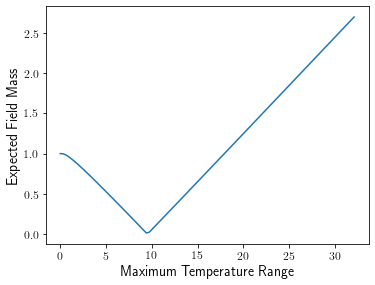

In [6]:
egtemps = np.linspace(0, max(freqs), 100)
plt.plot(egtemps, np.abs([th_masses(phi0, lamb, 0., tem, 0.) for tem in egtemps]))
plt.xlabel('Maximum Temperature Range')
plt.ylabel('Expected Field Mass')
plt.show()

In [7]:
#gamma = list_gamma[0]
#for temp in list_temp[::100]:
#    print('temp, gamma:', temp, gamma)
#    field = classical_field(gamma, temp)
#    field = np.asarray([np.roll(slice, nLat//2) for slice in field])
#    fftfield = np.abs(np.fft.fftshift(np.fft.fft2(field)))**2.
#    fig, ax = plt.subplots(1, 2, figsize = (10, 4))
#    im = ax[0].imshow(field, aspect='auto', interpolation='none', origin='lower')
#    clb = plt.colorbar(im, ax = ax[0])
#    im = ax[1].imshow(fftfield, aspect='auto', interpolation='none', origin='lower')
#    clb = plt.colorbar(im, ax = ax[1])
#    plt.suptitle('Temperature = '+str(temp))
#    plt.show()

#gamma = 0
#for temp in list_temp:
#    fig, ax = plt.subplots(1, 1, figsize = (20,4))
#   plt.plot(freqs, pspec(phi0, temp, 0.), label='theoretical')
#    fld = classical_field(gamma, temp)[0]
#    plt.plot(freqs, np.abs(np.fft.fftshift(np.fft.fft(fld)))**2./nLat**2, 'o', ms=1, label='data')
#    plt.legend(); plt.show()

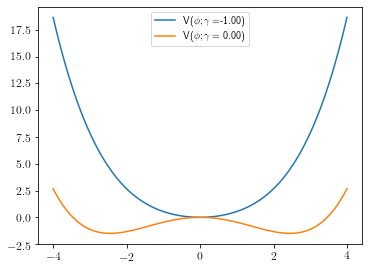

In [8]:
xlist = np.linspace(-4, 4, 100)
plt.figure()
[plt.plot(xlist, [V(x, lamb, gam) for x in xlist], label=f'V($\phi; \gamma = $%5.2f)'%(gam)) for gam in [-1, 0]]#, 0.25, 0.5]]
plt.legend(); plt.show()

### Extract data from files

In [9]:
list_gamma = [0.]
list_temp = np.arange(1, 11, 1)[-1::]/10.; print(list_temp)
fine_temp_list = np.linspace(min(list_temp), max(list_temp), 100)
filter_size = 0.

[1.]


In [10]:
all_data = np.asarray([[[extract_sim(nTime, nLat, temp, phi0, lamb, m2eff, gamma, sim, filter_size) for sim in range(lSim, nSims)] for gamma in list_gamma] for temp in list_temp])

In [11]:
#dataPS = lambda tem, sim, time: np.abs(np.fft.fftshift(np.fft.fft(all_data[tem][0][sim][0][time])))**2./nLat**2.
#for tem in range(len(list_temp)):
#    time = 0
#    fig, ax = plt.subplots(1, 1, figsize = (20,4))
#    plt.plot(freqs, pspec(phi0, list_temp[tem], 0.))
#    plt.plot(freqs, np.mean([dataPS(tem, sim, time) for sim in range(nSims-lSim)], axis=0), 'o', linestyle='None', ms=2)
##    [plt.plot(freqs, dataPS(tem, sim, time), 'o', ms=2) for sim in range(nSims-lSim)]
#    plt.show()

4


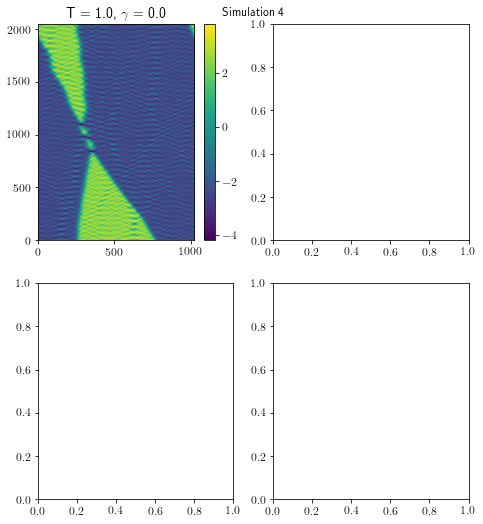

In [12]:
sim = random.randint(0, nSims-lSim-1); print(sim)

fig, ax = plt.subplots(len(list_gamma)+1, len(list_temp)+1, figsize = (4*len(list_temp)+4, 4*len(list_gamma)+4))
for gamma in range(len(list_gamma)):
    for temp in range(len(list_temp)):
        im0 = ax[gamma][temp].imshow(all_data[temp][gamma][sim][0], aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im0, ax = ax[gamma][temp])
        ax[gamma][temp].set_title('T = '+str(list_temp[temp])+f', $\gamma$ = '+str(list_gamma[gamma]))
plt.suptitle('Simulation '+str(sim))
plt.show()

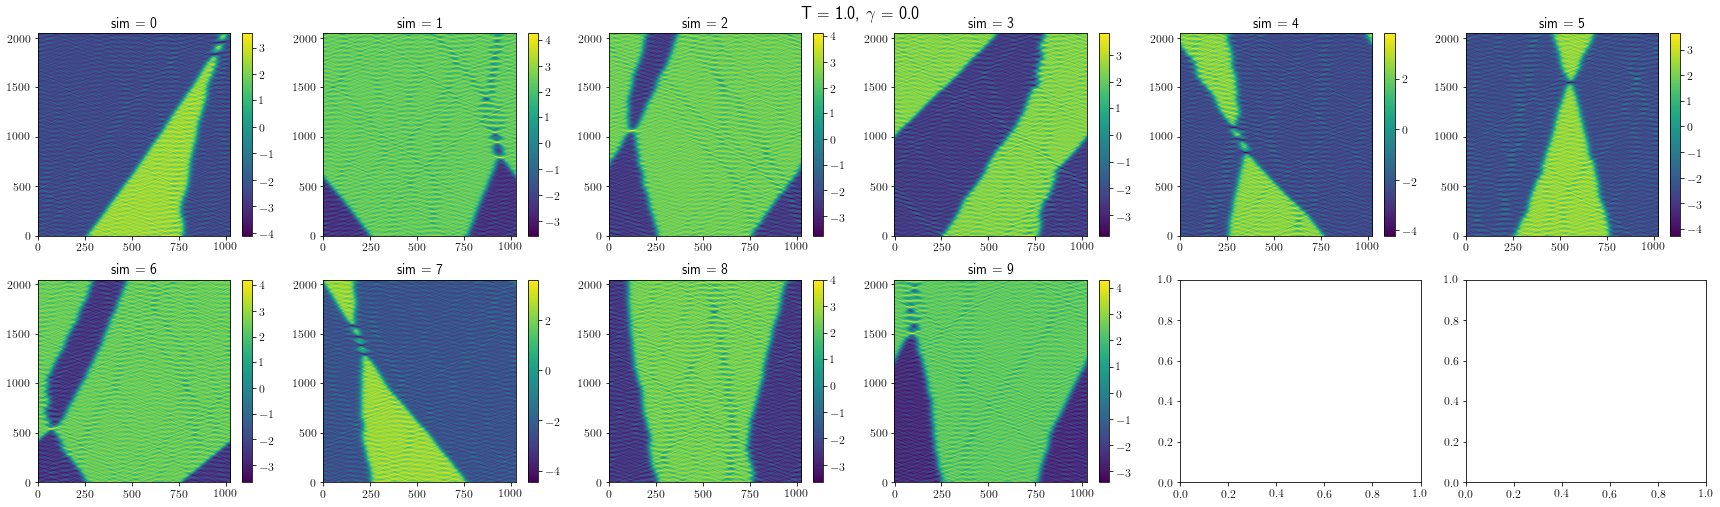

In [13]:
temp = len(list_temp)//2
gamma = 0
div = 6
fig, ax = plt.subplots(int(np.ceil((nSims-lSim)/div)), div, figsize = (div*4, 4.*(nSims+1)//div))
io = -1
for sim in range(nSims-lSim):
    if sim % div == 0: io += 1
    im0 = ax[io][sim%div].imshow(all_data[temp][gamma][sim][0], aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im0, ax = ax[io][sim%div])
    ax[io][sim%div].set_title('sim = '+str(sim))
plt.suptitle('T = '+str(list_temp[temp])+f', $\gamma$ = '+str(list_gamma[gamma]), weight=10, size='xx-large', y=1)
plt.tight_layout(); plt.show()

# Get profile of omega ^2

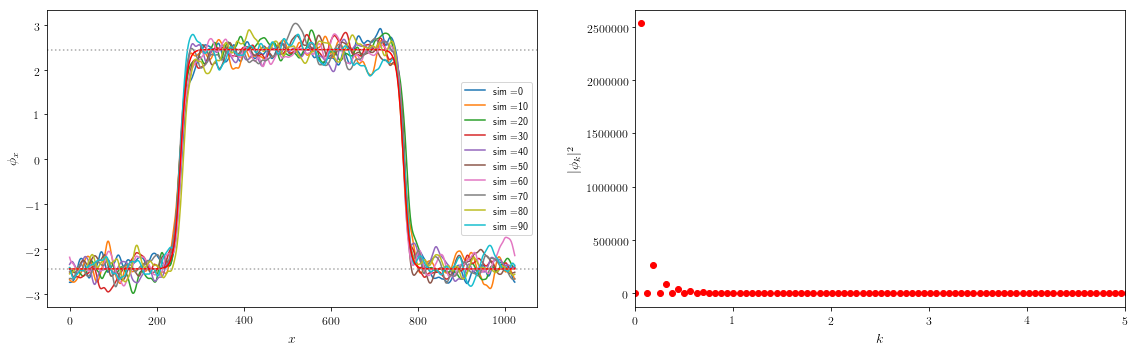

In [14]:
wall_profile = np.mean(np.asarray(np.reshape(np.genfromtxt('/gpfs/dpirvu/thermal_bubbles/phi4_gam0.0000_t1024_x1024_fields.dat'), (nLat, nLat))), axis=0)
wall_PS = np.abs(np.fft.fftshift(np.fft.fft(wall_profile)))**2.

jump = 10
temp = 0
time = 10

fig, ax = plt.subplots(1, 2, figsize = (20, 5))

[ax[0].plot(np.arange(nLat), all_data[temp][0][sim][0][time], label='sim ='+str(sim)) for sim in range(0, nSims-lSim, jump)]

ax[0].plot(np.arange(nLat), wall_profile, 'r')
ax[0].set_xlabel(f'$x$'); ax[0].set_ylabel(f'$\phi_x$')
ax[0].axhline(-m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
ax[0].axhline(m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
ax[1].plot(freqs, wall_PS, 'ro')
ax[1].set_xlim(0, 5)
ax[1].set_xlabel(f'$k$'); ax[1].set_ylabel(f'$|\phi_k|^2$')
ax[0].legend(); plt.show()

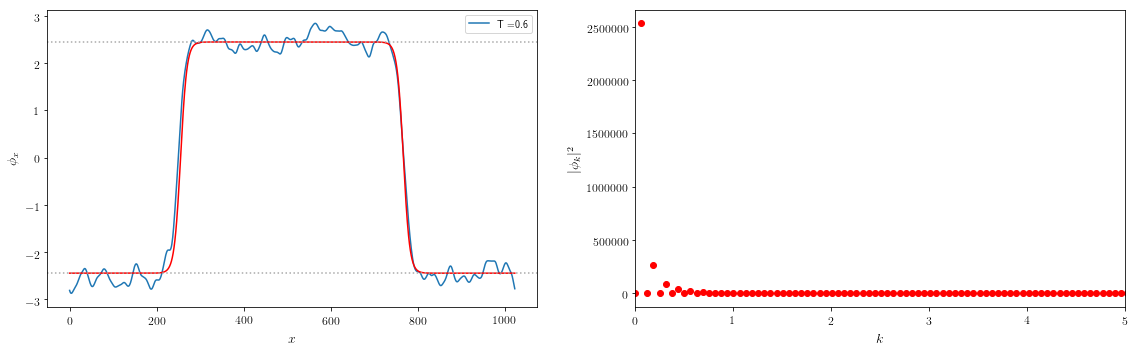

In [15]:
jump = 2
sim = 1

fig, ax = plt.subplots(1, 2, figsize = (20, 5))

[ax[0].plot(np.arange(nLat), all_data[temp][0][sim][0][time], label='T ='+str(list_temp[temp])) for temp in range(len(list_temp)-1, -1, -jump)]

ax[0].plot(np.arange(nLat), wall_profile, 'r')
ax[0].set_xlabel(f'$x$'); ax[0].set_ylabel(f'$\phi_x$')
ax[0].axhline(-m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
ax[0].axhline(m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
ax[1].plot(freqs, wall_PS, 'ro')
ax[1].set_xlim(0, 5)
ax[1].set_xlabel(f'$k$'); ax[1].set_ylabel(f'$|\phi_k|^2$')
ax[0].legend(); plt.show()

# Temp = 0.6 

temperature =  0.6
time =  0 0.07029923585186545
time =  51 0.05490352090012904
time =  102 0.037076961334051646
time =  153 0.026762710604750353
time =  204 0.02077308697006736


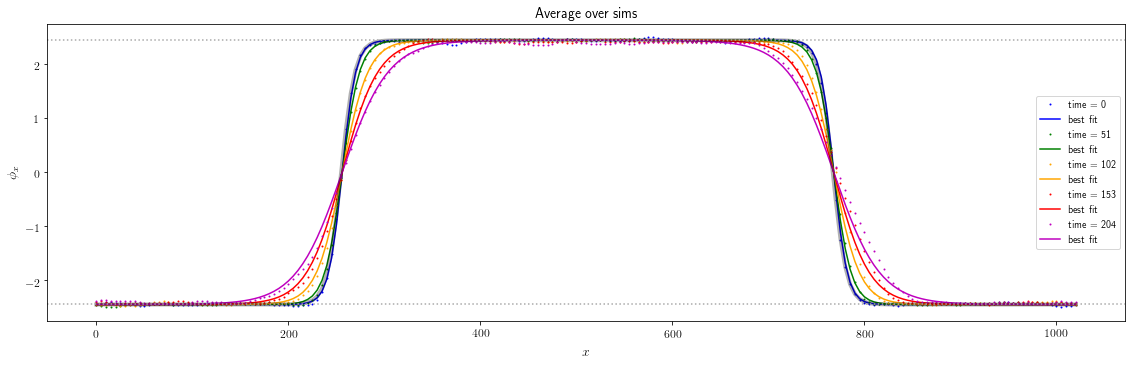

In [16]:
def tanh_fit(x, a1, a2, a3):
    return a1*(np.tanh(a2 * (x-nLat/4.)) - np.tanh(a2*(x-3.*nLat/4.))) + a3

def tanh_fit(x, a2):
    a1 = np.sqrt(m2eff*6./lamb)
    a3 = - np.sqrt(m2eff*6./lamb)
    return a1*(np.tanh(a2 * (x-nLat/4.)) - np.tanh(a2*(x-3.*nLat/4.))) + a3

for temp in range(len(list_temp)):
    print('temperature = ', list_temp[temp])
    list_time = [int(time) for time in np.linspace(0, nTime//10, 5)]
    list_pos = np.arange(nLat)[::5]
    colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
    fig, ax = plt.subplots(1, 1, figsize = (20, 5))
    for time in list_time:
        col = next(colors)
        curve = np.mean([all_data[temp][0][sim][0][time] for sim in range(nSims-lSim)], axis=0)[::5]
        plt.plot(list_pos, curve, label='time = '+str(time), marker = 'o', ms=1, color=col, ls='None')
        popt, pcov = scp.optimize.curve_fit(tanh_fit, list_pos, curve)
        plt.plot(list_pos, tanh_fit(list_pos, *popt), label='best fit', color=col)
        print('time = ', time, *popt)
    plt.plot(list_pos, wall_profile[::5], 'k', linewidth=4, alpha=0.3)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$\phi_x$')
    plt.axhline(-m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
    plt.axhline(m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
    plt.title('Average over sims')
    plt.legend(); plt.show()

# Temp = 1. 

temperature =  1.0
time =  0 0.07139664649182273
time =  51 0.040846670817478684
time =  102 0.023458490895447697
time =  153 0.0162642287481265
time =  204 0.012365302950380207


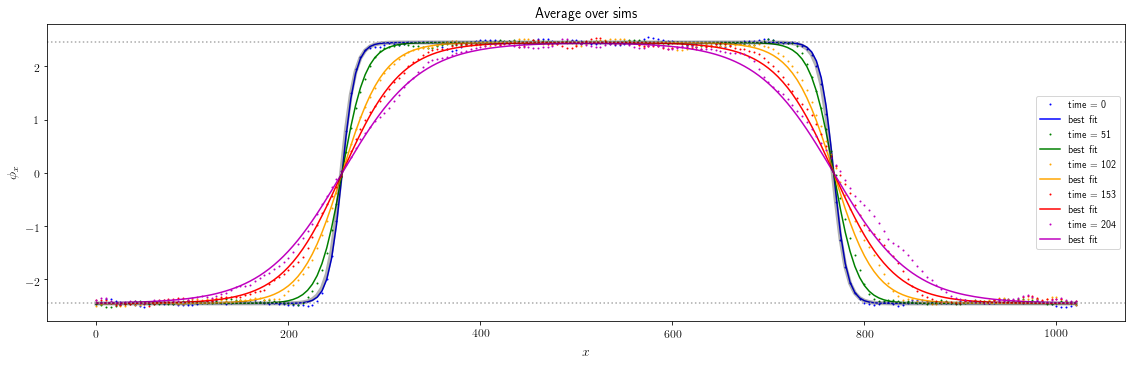

In [17]:
def tanh_fit(x, a1, a2, a3):
    return a1*(np.tanh(a2 * (x-nLat/4.)) - np.tanh(a2*(x-3.*nLat/4.))) + a3

def tanh_fit(x, a2):
    a1 = np.sqrt(m2eff*6./lamb)
    a3 = - np.sqrt(m2eff*6./lamb)
    return a1*(np.tanh(a2 * (x-nLat/4.)) - np.tanh(a2*(x-3.*nLat/4.))) + a3

for temp in range(len(list_temp)):
    print('temperature = ', list_temp[temp])
    list_time = [int(time) for time in np.linspace(0, nTime//10, 5)]
    list_pos = np.arange(nLat)[::5]
    colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
    fig, ax = plt.subplots(1, 1, figsize = (20, 5))
    for time in list_time:
        col = next(colors)
        curve = np.mean([all_data[temp][0][sim][0][time] for sim in range(nSims-lSim)], axis=0)[::5]
        plt.plot(list_pos, curve, label='time = '+str(time), marker = 'o', ms=1, color=col, ls='None')
        popt, pcov = scp.optimize.curve_fit(tanh_fit, list_pos, curve)
        plt.plot(list_pos, tanh_fit(list_pos, *popt), label='best fit', color=col)
        print('time = ', time, *popt)
    plt.plot(list_pos, wall_profile[::5], 'k', linewidth=4, alpha=0.3)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$\phi_x$')
    plt.axhline(-m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
    plt.axhline(m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
    plt.title('Average over sims')
    plt.legend(); plt.show()